# Computer Vision Approach (Roundabout Detection)

## Import Libraries

In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path
from IPython.display import display, Image

## Dataset Preparation
- Using `opencv` to generate more pictures with augmentations like flip and rotation.
- Adding padding and placing the roundabout in a random part of the image.
- Setting their bounding boxes and creating txt files of them to be compatible with YOLOv8.

In [5]:
input_folder = 'image_dataset\others'
output_folder = 'image_dataset\others_augmented'

os.makedirs(output_folder, exist_ok=True)

def random_rotation(image):
    angle = random.uniform(0, 180)
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), borderMode=cv2.BORDER_REFLECT)
    return rotated_image

def random_flip(image):
    flip_code = random.choice([-1, 0, 1])
    flipped_image = cv2.flip(image, flip_code)
    return flipped_image

def place_in_black_background(image, canvas_size=(500, 500)):
    canvas = np.zeros((canvas_size[0], canvas_size[1], 3), dtype=np.uint8)
    img_height, img_width = image.shape[:2]

    max_x = canvas_size[1] - img_width
    max_y = canvas_size[0] - img_height
    if max_x < 0 or max_y < 0:
        raise ValueError("Canvas size must be larger than the image size.")

    x_offset = random.randint(0, max_x)
    y_offset = random.randint(0, max_y)

    canvas[y_offset:y_offset + img_height, x_offset:x_offset + img_width] = image
    return canvas

file_counter = 1
num_augmentations = 8

for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)

        for _ in range(num_augmentations):
            augmented_image = random_rotation(image)
            augmented_image = random_flip(augmented_image)
            final_image = place_in_black_background(augmented_image, canvas_size=(1000, 1000))
            output_filename = f'{file_counter}.png'
            output_image_path = os.path.join(output_folder, output_filename)
            cv2.imwrite(output_image_path, final_image)
            file_counter += 1

print("Processing complete. Augmented non-roundabout images are saved in the output folder.")

Processing complete. Augmented non-roundabout images are saved in the output folder.


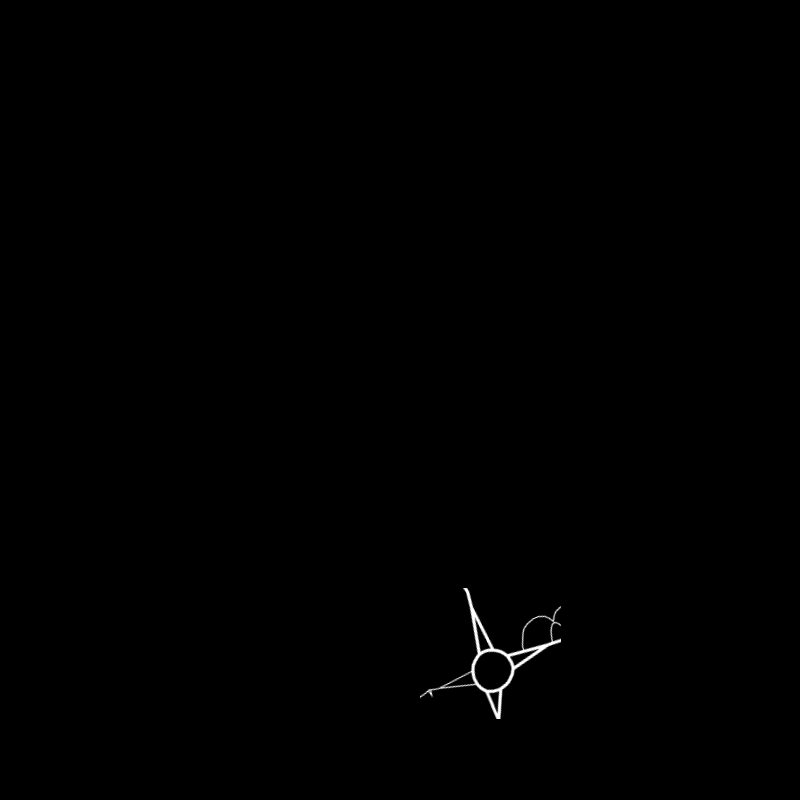

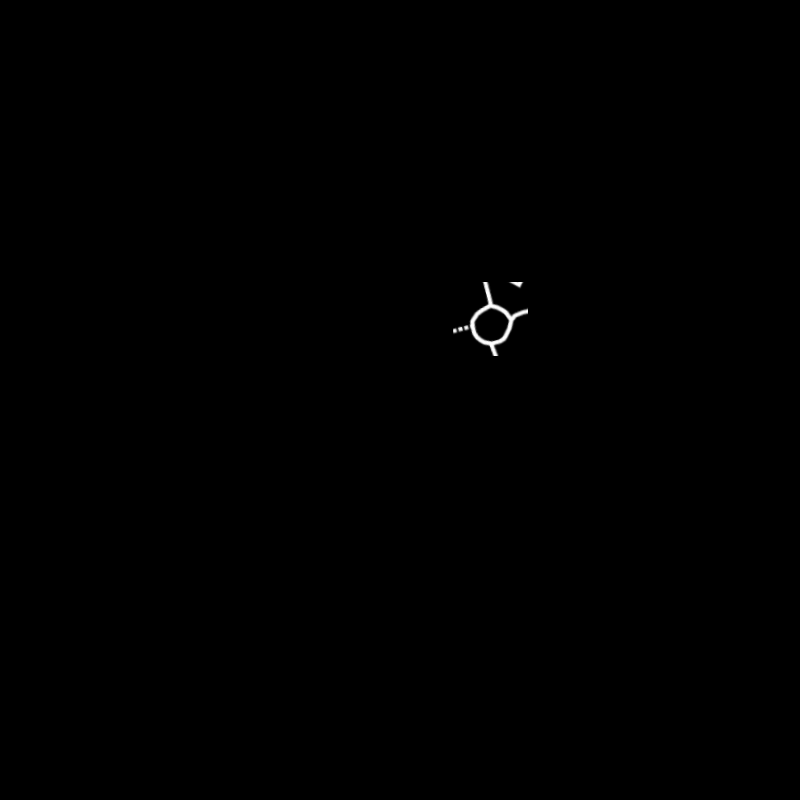

In [3]:
display(Image(filename='image_outputs\\1.png'))
display(Image(filename='image_outputs\\52.png'))

## Model Initialization
- Train YOLOv8 nano model on the dataset.

In [ ]:
# Load the YOLOv8 Nano model
model = YOLO('yolov8n.pt')

# Train the model
model.train(
    data='dataset.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='yolov8n_roundabouts',
)

- Load best weights of our fine-tuned model

In [14]:
model = YOLO('best.pt')

## Model Predictions
- Using our fine tuned model to detect roundabouts

In [ ]:


def process_image(model, image_path, output_dir):    
    results = model(image_path)
    plot = results[0].plot()
    plot_rgb = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB

    # Save the result
    output_path = output_dir / f"{image_path.stem}_result.png"
    cv2.imwrite(str(output_path), plot_rgb)

# Directory containing images
image_dir = Path('image_dataset\\test')

# Create output directory
output_dir = Path('yolo_results')
output_dir.mkdir(exist_ok=True)

for image_path in image_dir.glob('*.png'):
    process_image(model, image_path, output_dir)

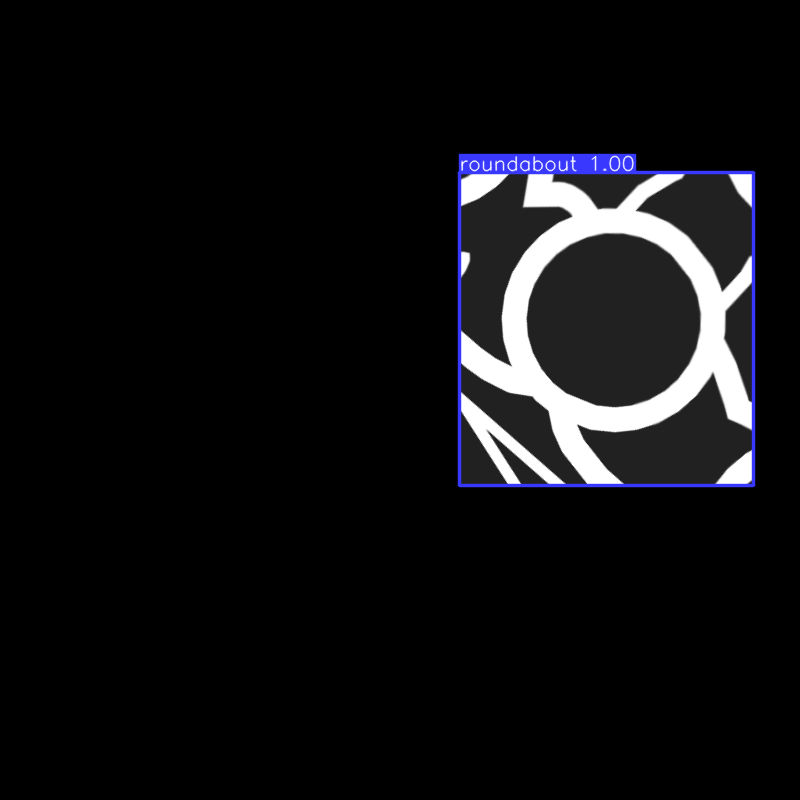

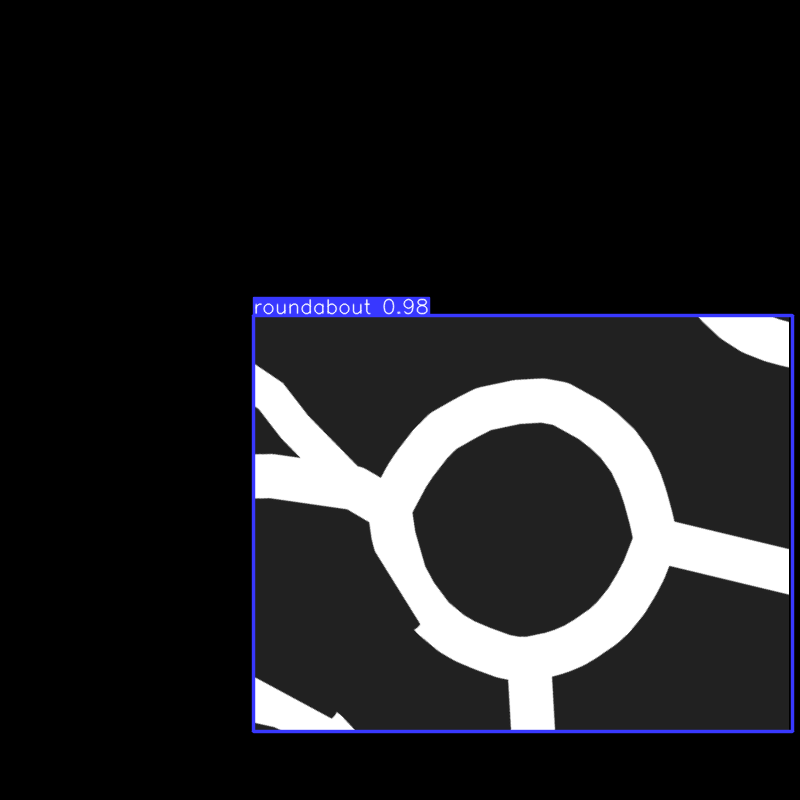

In [2]:
display(Image(filename='yolo_results\\239_result.png'))
display(Image(filename='yolo_results\\341_result.png'))